# Packages and Dataset Imports

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from imblearn.over_sampling import SMOTE
from sklearn import model_selection

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=15)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns

In [2]:
import tarfile
import urllib

#dir_path = "https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/HR_Analytics/main/"
#data_path = os.path.join(dir_path, "data")
#original_file_path = os.path.join(data_path, "hr_attrition.csv")
#df = pd.read_csv(original_file_path)

url = 'https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/HR_Analytics/main/data/hr_attrition.csv'
df = pd.read_csv(url)

In [3]:
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


# Custom Functions Summary
* From the data cleaning/transformation notebook

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### returns DataFrame with standardized numerical variables and encoded categorical variables
def transform(data):
    # first dropping the unnecessary columns
    if 'EmployeeCount' in list(data.columns):
        data = data.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis = 'columns')
    
    # categorizing features
    ohe_vars = ['Department', 'Gender', 'MaritalStatus', 'OverTime']
    ordinal_vars = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
    lab_vars = ['EducationField', 'JobRole']
    
    # filtering the data to exclude outliers in the YearsAtCompany and TotalWorkingYears variables
    data = data[data['YearsAtCompany'] < 30]
    data = data[data['TotalWorkingYears'] < 30]
    
    # giving the original values for education field and job role to be used later, if needed
    inverse_edu_job = data[lab_vars]
    
    df_num = [] # list of numerical variables
    cat_vars = ordinal_vars + ohe_vars + lab_vars
    cat_vars.append('Attrition') # target variable
    for i in list(data.columns):
        if i not in cat_vars:
            df_num.append(i)
    
    # ordinal encoding of the ordinal variables
    if type(data['BusinessTravel'][0]) == str:
        data['BusinessTravel'] = data['BusinessTravel'].replace({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
    ord_pipeline = Pipeline([('ord_enc', OrdinalEncoder())])
    data[ordinal_vars] = ord_pipeline.fit_transform(data[ordinal_vars])

    # label encoding the education field and job role
    lbl_edu = LabelEncoder()
    edu_encoded = lbl_edu.fit_transform(data[['EducationField']])
    lbl_job = LabelEncoder()
    job_encoded = lbl_job.fit_transform(data[['JobRole']])
    data['EducationField'] = edu_encoded
    data['JobRole'] = job_encoded

    
    # standardizing numerical variables
    num_pipeline = Pipeline([('scaler', StandardScaler())])
    num_std = num_pipeline.fit_transform(data[df_num])
    data[df_num] = num_std
    
    # using pd.get_dummies in lieu of OneHotEncoder
    data = pd.concat([data, pd.get_dummies(data[ohe_vars], drop_first = True)], axis = 'columns')
    data = data.drop(ohe_vars, axis = 1)
    
    if type(data['Attrition'][0]) == str:
        data['Attrition'] = data['Attrition'].replace({'Yes': 1, 'No': 0})
    
    return data, inverse_edu_job


### returns DataFrame with non-standardized numerical variables and encoded categorical variables
def transform_encoding(data):
    # first dropping the unnecessary columns
    if 'EmployeeCount' in list(data.columns):
        data = data.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis = 'columns')
    
    # categorizing features
    ohe_vars = ['Department', 'Gender', 'MaritalStatus', 'OverTime']
    ordinal_vars = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
    lab_vars = ['EducationField', 'JobRole']
    
    # filtering the data to exclude outliers in the YearsAtCompany and TotalWorkingYears variables
    data = data[data['YearsAtCompany'] < 30]
    data = data[data['TotalWorkingYears'] < 30]
    
    # ordinal encoding of the ordinal variables
    if type(data['BusinessTravel'][0]) == str:
        data['BusinessTravel'] = data['BusinessTravel'].replace({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
    ord_pipeline = Pipeline([('ord_enc', OrdinalEncoder())])
    data[ordinal_vars] = ord_pipeline.fit_transform(data[ordinal_vars])

    # label encoding the education field and job role
    lbl_edu = LabelEncoder()
    edu_encoded = lbl_edu.fit_transform(data[['EducationField']])
    lbl_job = LabelEncoder()
    job_encoded = lbl_job.fit_transform(data[['JobRole']])
    data['EducationField'] = edu_encoded
    data['JobRole'] = job_encoded
    
    # using pd.get_dummies in lieu of OneHotEncoder
    data = pd.concat([data, pd.get_dummies(data[ohe_vars], drop_first = True)], axis = 'columns')
    data = data.drop(ohe_vars, axis = 1)
    
    if type(data['Attrition'][0]) == str:
        data['Attrition'] = data['Attrition'].replace({'Yes': 1, 'No': 0})
    
    return data

In [5]:
df_enc = transform_encoding(df)
df_std, inverse_array = transform(df)
df_enc.head()

C:\Users\Steven\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Steven\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,...,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Research & Development,Department_Sales,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1,1.0,1102,1,1.0,1,1,1.0,94,...,6,4,0,5,0,1,0,0,1,1
1,49,0,2.0,279,8,0.0,1,2,2.0,61,...,10,7,1,7,1,0,1,1,0,0
2,37,1,1.0,1373,2,1.0,4,4,3.0,92,...,0,0,0,0,1,0,1,0,1,1
3,33,0,2.0,1392,3,3.0,1,5,3.0,56,...,8,7,3,0,1,0,0,1,0,1
4,27,0,1.0,591,2,0.0,3,7,0.0,40,...,2,2,2,2,1,0,1,1,0,0


# Other Testing Before Starting with Models

> ## for Correlation with Target

In [6]:
corr = df_enc.corr()['Attrition'].sort_values()
print("Top 10 highest correlations:")
print(corr.tail(10))
print("-"*25)

print("Top 10 lowest correlations:")
print(corr.head(10))

Top 10 highest correlations:
EducationField          0.020289
Gender_Male             0.037651
NumCompaniesWorked      0.048371
JobRole                 0.068069
DistanceFromHome        0.080935
Department_Sales        0.083978
BusinessTravel          0.131544
MaritalStatus_Single    0.181020
OverTime_Yes            0.253038
Attrition               1.000000
Name: Attrition, dtype: float64
-------------------------
Top 10 lowest correlations:
TotalWorkingYears      -0.187486
YearsInCurrentRole     -0.172973
JobLevel               -0.167773
YearsAtCompany         -0.165175
YearsWithCurrManager   -0.162652
Age                    -0.161395
MonthlyIncome          -0.158067
StockOptionLevel       -0.141431
JobInvolvement         -0.128859
JobSatisfaction        -0.108815
Name: Attrition, dtype: float64


Some correlation between the attrition variable and a few of the variables present in the dataset, but all with an absolute value less than 0.26, so nothing too concerning.

In [7]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

> ## Information Leakage

Attempting to identify possible information leakage (information that is updated after an employee leaves) <br>
**Note:** Using intuition to choose the features to look at here

In [8]:
df_enc[df_enc['Attrition'] == 1][['Attrition', 'BusinessTravel', 'DailyRate', 'JobLevel', 'NumCompaniesWorked', 'StockOptionLevel', 'YearsInCurrentRole', 'YearsWithCurrManager']].describe()

,Attrition,BusinessTravel,DailyRate,JobLevel,NumCompaniesWorked,StockOptionLevel,YearsInCurrentRole,YearsWithCurrManager
count,232.0,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,1.0,1.245690,758.314655,0.590517,2.935345,0.525862,2.728448,2.737069
std,0.0,0.538539,401.553596,0.882978,2.667773,0.862506,2.940899,3.071275
min,1.0,0.000000,103.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.000000,409.500000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.0,1.000000,713.500000,0.000000,1.000000,0.000000,2.000000,2.000000
75%,1.0,2.000000,1094.000000,1.000000,5.000000,1.000000,4.000000,4.000000
max,1.0,2.000000,1496.000000,4.000000,9.000000,3.000000,15.000000,14.000000


In [9]:
df_enc[df_enc['Attrition'] == 0][['Attrition', 'BusinessTravel', 'DailyRate', 'JobLevel', 'NumCompaniesWorked', 'StockOptionLevel', 'YearsInCurrentRole', 'YearsWithCurrManager']].describe()

,Attrition,BusinessTravel,DailyRate,JobLevel,NumCompaniesWorked,StockOptionLevel,YearsInCurrentRole,YearsWithCurrManager
count,1185.0,1185.000000,1185.000000,1185.000000,1185.000000,1185.000000,1185.000000,1185.000000
mean,0.0,1.056540,814.209283,1.061603,2.610127,0.853165,4.393249,4.275949
std,0.0,0.525701,403.499334,1.050460,2.449814,0.845522,3.610788,3.527015
min,0.0,0.000000,105.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,1.000000,480.000000,0.000000,1.000000,0.000000,2.000000,2.000000
50%,0.0,1.000000,819.000000,1.000000,2.000000,1.000000,3.000000,3.000000
75%,0.0,1.000000,1176.000000,2.000000,4.000000,1.000000,7.000000,7.000000
max,0.0,2.000000,1499.000000,4.000000,9.000000,3.000000,18.000000,17.000000


I'm assuming that the features are not updated after an employee leaves, but are reflective of their time prior. `JobLevel` and `StockOptionLevel` are the categories which make me most suspicious, but I would imagine that differences between the two average levels has more to do with the types of employees that leave most often (lower level).

# Train-Test Split

In [10]:
X_enc = df_enc.drop('Attrition', axis = 'columns')
y_enc = df_enc['Attrition']

X_std = df_std.drop('Attrition', axis = 'columns')
y_std = df_std['Attrition']

In [11]:
from sklearn.model_selection import train_test_split
X_enc_train, X_enc_val_test, y_enc_train, y_enc_val_test = train_test_split(X_enc, y_enc, test_size = 0.3, random_state = 6)
X_std_train, X_std_val_test, y_std_train, y_std_val_test = train_test_split(X_std, y_std, test_size = 0.3, random_state = 6)

> ## Test-Validation Split

In [12]:
X_enc_val, X_enc_test, y_enc_val, y_enc_test = train_test_split(X_enc_val_test, y_enc_val_test, test_size = 0.5, random_state = 6)
X_std_val, X_std_test, y_std_val, y_std_test = train_test_split(X_std_val_test, y_std_val_test, test_size = 0.5, random_state = 6)

# Baseline Model

> ## Dummy Classifier

In [13]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_enc_train, y_enc_train)

DummyClassifier()

In [14]:
dummy_clf.score(X_enc_val, y_enc_val)  # accuracy

0.8075117370892019

In [15]:
from sklearn import metrics
metrics.precision_score(y_enc_val, dummy_clf.predict(X_enc_val))

C:\Users\Steven\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

> ## Evaluation Metrics

In [39]:
#ROC Plot
def plot_roc_curve(fpr, tpr, roc_auc):
#    plt.style.use('classic')
    sns.set_style("darkgrid")
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b+', label = 'AUC = %0.2f' % roc_auc, linestyle = '-')
    plt.fill_between(fpr, tpr, alpha = 0.5, color='gold')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [40]:
#Precision / Recall Plot
def plot_pr_curve(precision, recall, average_precision):
#    plt.style.use('classic')
    sns.set_style("darkgrid")
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='red')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

In [41]:
#plt.style.available

> ## Classification Score
Evaluates model on training and validation sets

In [42]:
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("Accuracy: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train == False:
        print("Validation Result:\n")
        print("Accuracy: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("AUC-ROC: {0:.3f}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(pd.DataFrame(metrics.confusion_matrix(y_val, clf.predict(X_val),
                                                                  labels=[0,1]),index=['true:0','true:1'], columns=['pred:0','pred:1'])))
        
        print("End of validation Result\n")

# Logistical Regression
* with SMTOE: Accuracy: 0.8826, AUC-ROC: 0.695
* without SMOTE: Accuracy: 0.6714, AUC-ROC: 0.685

In [43]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C = 0.1, max_iter = 500, random_state = 6)
clf.fit(X_std_train, y_std_train)

LogisticRegression(C=0.1, max_iter=500, random_state=6)

Validation Result:

Accuracy: 0.8826



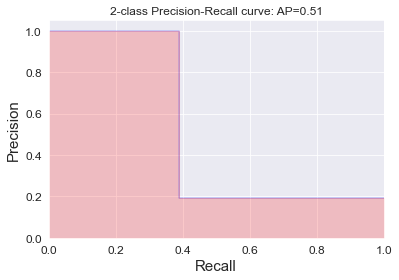

AUC-ROC: 0.695



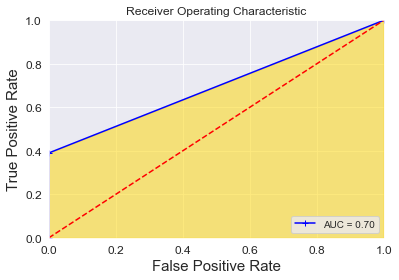

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       172
           1       1.00      0.39      0.56        41

    accuracy                           0.88       213
   macro avg       0.94      0.70      0.75       213
weighted avg       0.90      0.88      0.86       213


Confusion Matrix: 
         pred:0  pred:1
true:0     172       0
true:1      25      16

End of validation Result



In [44]:
clf_score(clf, X_std_train, y_std_train, X_std_val, y_std_val, train = False)

> ## Over-Sampling with SMOTE<br>
There are many fewer employees that have left, the results might be different if the classes are rebalanced.

<AxesSubplot:xlabel='Attrition', ylabel='count'>

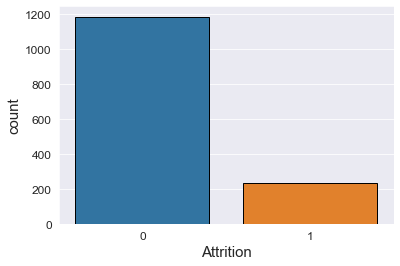

In [45]:
import seaborn as sns
sns.countplot(y_enc, edgecolor = 'black')

In [46]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_sample(X_std_train, y_std_train)

<AxesSubplot:xlabel='Attrition', ylabel='count'>

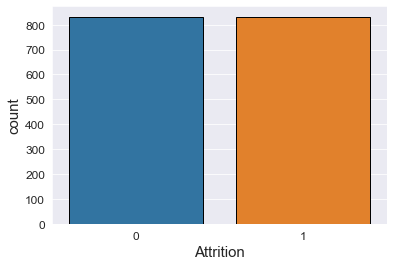

In [47]:
sns.countplot(y_train_sm, edgecolor = 'black')

In [48]:
clf_smote = LogisticRegression(C=0.001, random_state=42)
clf_smote.fit(X_train_sm, y_train_sm)

LogisticRegression(C=0.001, random_state=42)

Validation Result:

Accuracy: 0.6714



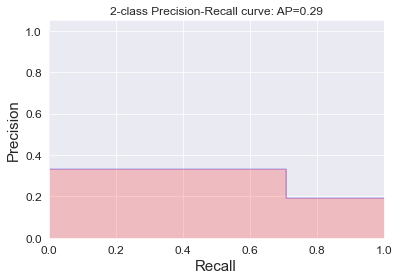

AUC-ROC: 0.685



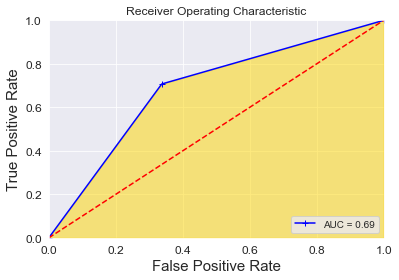

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.66      0.77       172
           1       0.33      0.71      0.45        41

    accuracy                           0.67       213
   macro avg       0.62      0.69      0.61       213
weighted avg       0.79      0.67      0.71       213


Confusion Matrix: 
         pred:0  pred:1
true:0     114      58
true:1      12      29

End of validation Result



In [49]:
clf_score(clf_smote, X_train_sm, y_train_sm, X_std_val, y_std_val, train = False)

# Random Forest
* with SMOTE: Accuracy: 0.8357, AUC-ROC: 0.629
* without SMOTE: Accuracy: 0.8263, AUC-ROC: 0.577

In [50]:
#here we are starting out with SMOTE (Synthetic Minority Oversampling Technique)
sm = SMOTE(random_state = 6)
X_enc_train_sm, y_enc_train_sm = sm.fit_sample(X_enc_train, y_enc_train)

In [51]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 40, random_state = 6)
clf.fit(X_enc_train_sm, y_enc_train_sm)

RandomForestClassifier(n_estimators=40, random_state=6)

Validation Result:

Accuracy: 0.8357



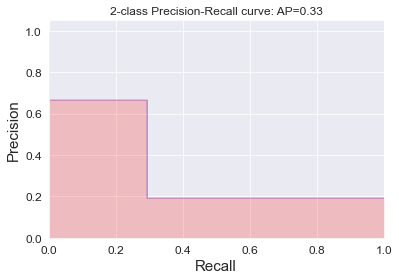

AUC-ROC: 0.629



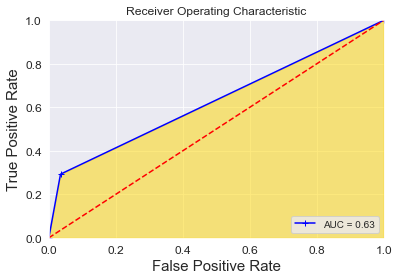

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.97      0.90       172
           1       0.67      0.29      0.41        41

    accuracy                           0.84       213
   macro avg       0.76      0.63      0.66       213
weighted avg       0.82      0.84      0.81       213


Confusion Matrix: 
         pred:0  pred:1
true:0     166       6
true:1      29      12

End of validation Result



In [52]:
clf_score(clf, X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, train = False)

> RF's results are much better than logistic regression<br>

> ## Trying **WITHOUT** SMOTE: results are slightly worse
> * with smote: Accuracy: 0.8357, roc auc score: 0.628
> * without smote: Accuracy: 0.8263, roc auc score: 0.576

In [53]:
clf = RandomForestClassifier(n_estimators = 40, random_state = 6)
clf.fit(X_enc_train, y_enc_train)

RandomForestClassifier(n_estimators=40, random_state=6)

Validation Result:

Accuracy: 0.8263



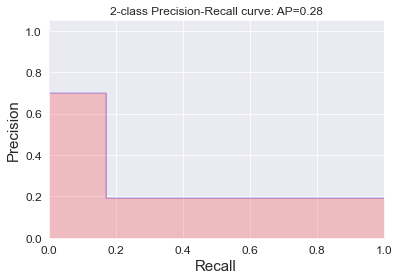

AUC-ROC: 0.577



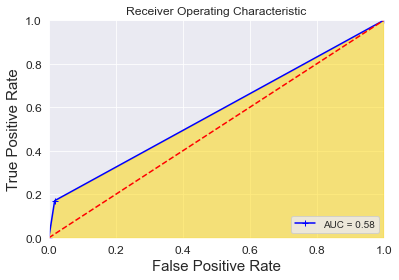

Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.98      0.90       172
           1       0.70      0.17      0.27        41

    accuracy                           0.83       213
   macro avg       0.77      0.58      0.59       213
weighted avg       0.81      0.83      0.78       213


Confusion Matrix: 
         pred:0  pred:1
true:0     169       3
true:1      34       7

End of validation Result



In [54]:
clf_score(clf, X_enc_train, y_enc_train, X_enc_val, y_enc_val, train = False)

# LightGBM LGBMClassifier
* with SMOTE: Accuracy: 0.8545, AUC-ROC score: 0.659
* without SMOTE: Accuracy: 0.8404, AUC-ROC: 0.632

In [55]:
from lightgbm import LGBMClassifier

In [56]:
#with smote
clf = LGBMClassifier(n_estimators = 40, random_state = 6)
clf.fit(X_enc_train_sm, y_enc_train_sm)

LGBMClassifier(n_estimators=40, random_state=6)

Validation Result:

Accuracy: 0.8545



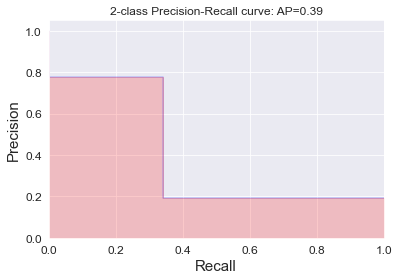

AUC-ROC: 0.659



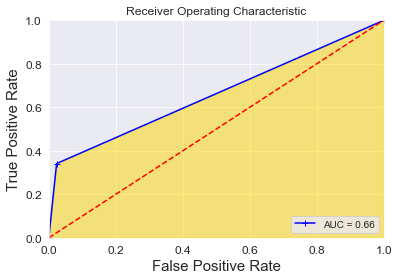

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.98      0.92       172
           1       0.78      0.34      0.47        41

    accuracy                           0.85       213
   macro avg       0.82      0.66      0.70       213
weighted avg       0.85      0.85      0.83       213


Confusion Matrix: 
         pred:0  pred:1
true:0     168       4
true:1      27      14

End of validation Result



In [57]:
clf_score(clf, X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, train = False)

In [58]:
#without smote
clf = LGBMClassifier(n_estimators = 40, random_state = 6)
clf.fit(X_enc_train, y_enc_train)

LGBMClassifier(n_estimators=40, random_state=6)

Validation Result:

Accuracy: 0.8404



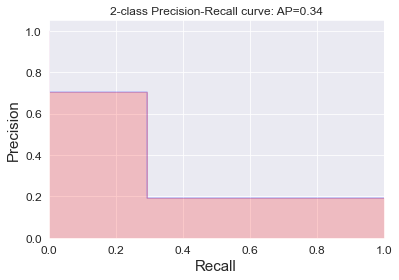

AUC-ROC: 0.632



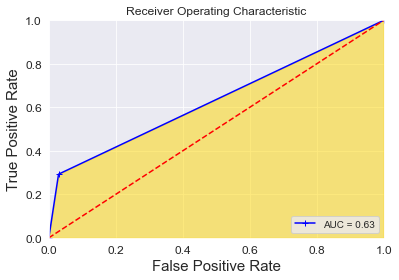

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.97      0.91       172
           1       0.71      0.29      0.41        41

    accuracy                           0.84       213
   macro avg       0.78      0.63      0.66       213
weighted avg       0.82      0.84      0.81       213


Confusion Matrix: 
         pred:0  pred:1
true:0     167       5
true:1      29      12

End of validation Result



In [59]:
clf_score(clf, X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, train = False)

### Compare to sklearn GradientBoostingClassifier

In [60]:
from sklearn.ensemble import GradientBoostingClassifier

In [61]:
clf = GradientBoostingClassifier(n_estimators = 40, random_state = 6)
clf.fit(X_enc_train_sm, y_enc_train_sm)

GradientBoostingClassifier(n_estimators=40, random_state=6)

Validation Result:

Accuracy: 0.8310



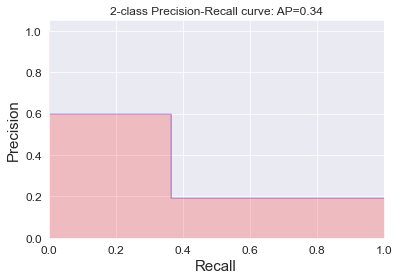

AUC-ROC: 0.654



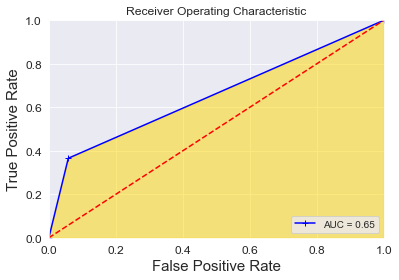

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.94      0.90       172
           1       0.60      0.37      0.45        41

    accuracy                           0.83       213
   macro avg       0.73      0.65      0.68       213
weighted avg       0.81      0.83      0.81       213


Confusion Matrix: 
         pred:0  pred:1
true:0     162      10
true:1      26      15

End of validation Result



In [62]:
clf_score(clf, X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, train = False)

Compared to than LGBMClassifier, about the same
* LGBMClassifier: Accuracy: 0.8404, AUC-ROC: 0.632
* GradientBoosting: Accuracy: 0.8310, AUC-ROC: 0.654

# XGBoost

In [63]:
import xgboost as xgb

In [64]:
clf = xgb.XGBClassifier(random_state = 6)
clf.fit(X_enc_train, y_enc_train)

[00:00:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Steven\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=6,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Validation Result:

Accuracy: 0.8404



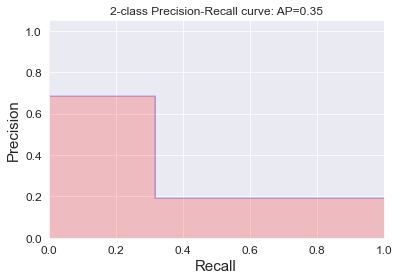

AUC-ROC: 0.641



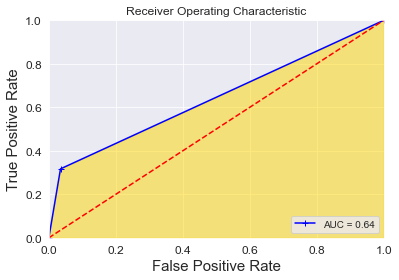

Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       172
           1       0.68      0.32      0.43        41

    accuracy                           0.84       213
   macro avg       0.77      0.64      0.67       213
weighted avg       0.82      0.84      0.82       213


Confusion Matrix: 
         pred:0  pred:1
true:0     166       6
true:1      28      13

End of validation Result



In [65]:
clf_score(clf, X_enc_train, y_enc_train, X_enc_val, y_enc_val, train = False)

# AdaBoost

In [66]:
from sklearn.ensemble import AdaBoostClassifier

In [67]:
clf = AdaBoostClassifier(n_estimators = 100, random_state = 6)
clf.fit(X_enc_train_sm, y_enc_train_sm)

AdaBoostClassifier(n_estimators=100, random_state=6)

Validation Result:

Accuracy: 0.8498



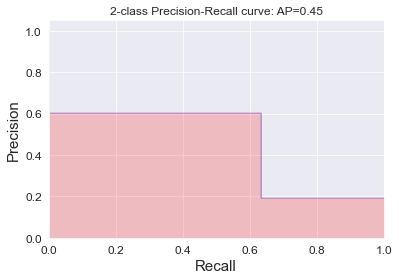

AUC-ROC: 0.768



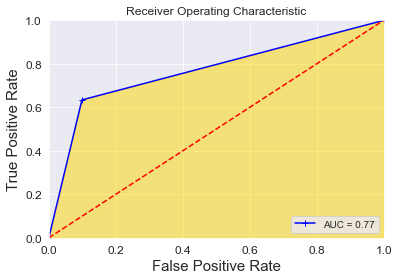

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       172
           1       0.60      0.63      0.62        41

    accuracy                           0.85       213
   macro avg       0.76      0.77      0.76       213
weighted avg       0.85      0.85      0.85       213


Confusion Matrix: 
         pred:0  pred:1
true:0     155      17
true:1      15      26

End of validation Result



In [68]:
clf_score(clf, X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, train = False)

In [69]:
from mlxtend.classifier import (
    StackingClassifier, 
)
clfs = [
    x() for x in [
        LogisticRegression,
        RandomForestClassifier,
        GradientBoostingClassifier
    ]
]
stack = StackingClassifier(
    classifiers=clfs,
    meta_classifier=LogisticRegression(),
)
kfold = model_selection.KFold(n_splits=10) #random_state=42
s = model_selection.cross_val_score(stack, X_enc, y_enc, scoring="roc_auc", cv=kfold)
print(f"{stack.__class__.__name__}  "
      f"AUC: {s.mean():.3f}  STD: {s.std():.2f}")

C:\Users\Steven\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Steven\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

StackingClassifier  AUC: 0.658  STD: 0.06


# Preliminary Results

After initial testing, the best models appeared to be the LGBMClassifier and AdaBoostClassifier. Some hyperparameter tuning with these models can be done to improve performance.

## LGBMClassifier Randomized Grid Search
* Before: with SMOTE: Accuracy: 0.8545, AUC-ROC score: 0.659
* After RandGridSearch: Accuracy: 0.8498, AUC-ROC: 0.656

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import random

In [ ]:
param_distribs = {
        'n_estimators': randint(low = 1, high = 150)
    }

lgbm = LGBMClassifier(random_state = 6)
rnd_search = RandomizedSearchCV(lgbm, param_distributions = param_distribs,
                                n_iter = 100, cv = 5, scoring = 'neg_mean_squared_error', random_state = 6)
rnd_search.fit(X_enc, y_enc)

In [ ]:
rnd_search.best_estimator_

In [ ]:
clf_best = LGBMClassifier(n_estimators=44, random_state=6) #max_depth=-1
clf_best.fit(X_enc_train_sm, y_enc_train_sm)

In [ ]:
clf_score(clf_best, X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, train = False)

## AdaBoostClassifier Randomized Grid Search
* Before: with SMOTE: Accuracy: 0.8498, AUC-ROC: 0.768
* After RandGridSearch: Accuracy: 0.8357, AUC-ROC: 0.740

In [ ]:
params = {
    'n_estimators': randint(low = 30, high = 100),
    'learning_rate': [random.random()]
}
ada = AdaBoostClassifier(random_state = 6)
rnd_search = RandomizedSearchCV(ada, param_distributions = params, n_iter = 100, scoring = 'neg_mean_squared_error', random_state = 6)

In [ ]:
rnd_search.fit(X_enc, y_enc)

In [ ]:
rnd_search.best_estimator_

In [ ]:
ada_best = AdaBoostClassifier(learning_rate=0.7733188879158778, n_estimators=45, random_state=6)
ada_best.fit(X_enc_train_sm, y_enc_train_sm)

In [ ]:
clf_score(ada_best, X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, train = False)

# Feature Importance

## Feature Importance Using RF

In [70]:
def plotImp(model, X , num = 33):
    feature_imp = pd.DataFrame({'Value':clf.feature_importances_,'Features':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 3)    
    sns.barplot(x="Value", y="Features", data=feature_imp.sort_values(by="Value", ascending=False)[0:num], palette='viridis_r')
#    plt.title('RF Features Importances')
#    plt.tight_layout()
#    plt.savefig('lgbm_importances-01.png')
    plt.show()

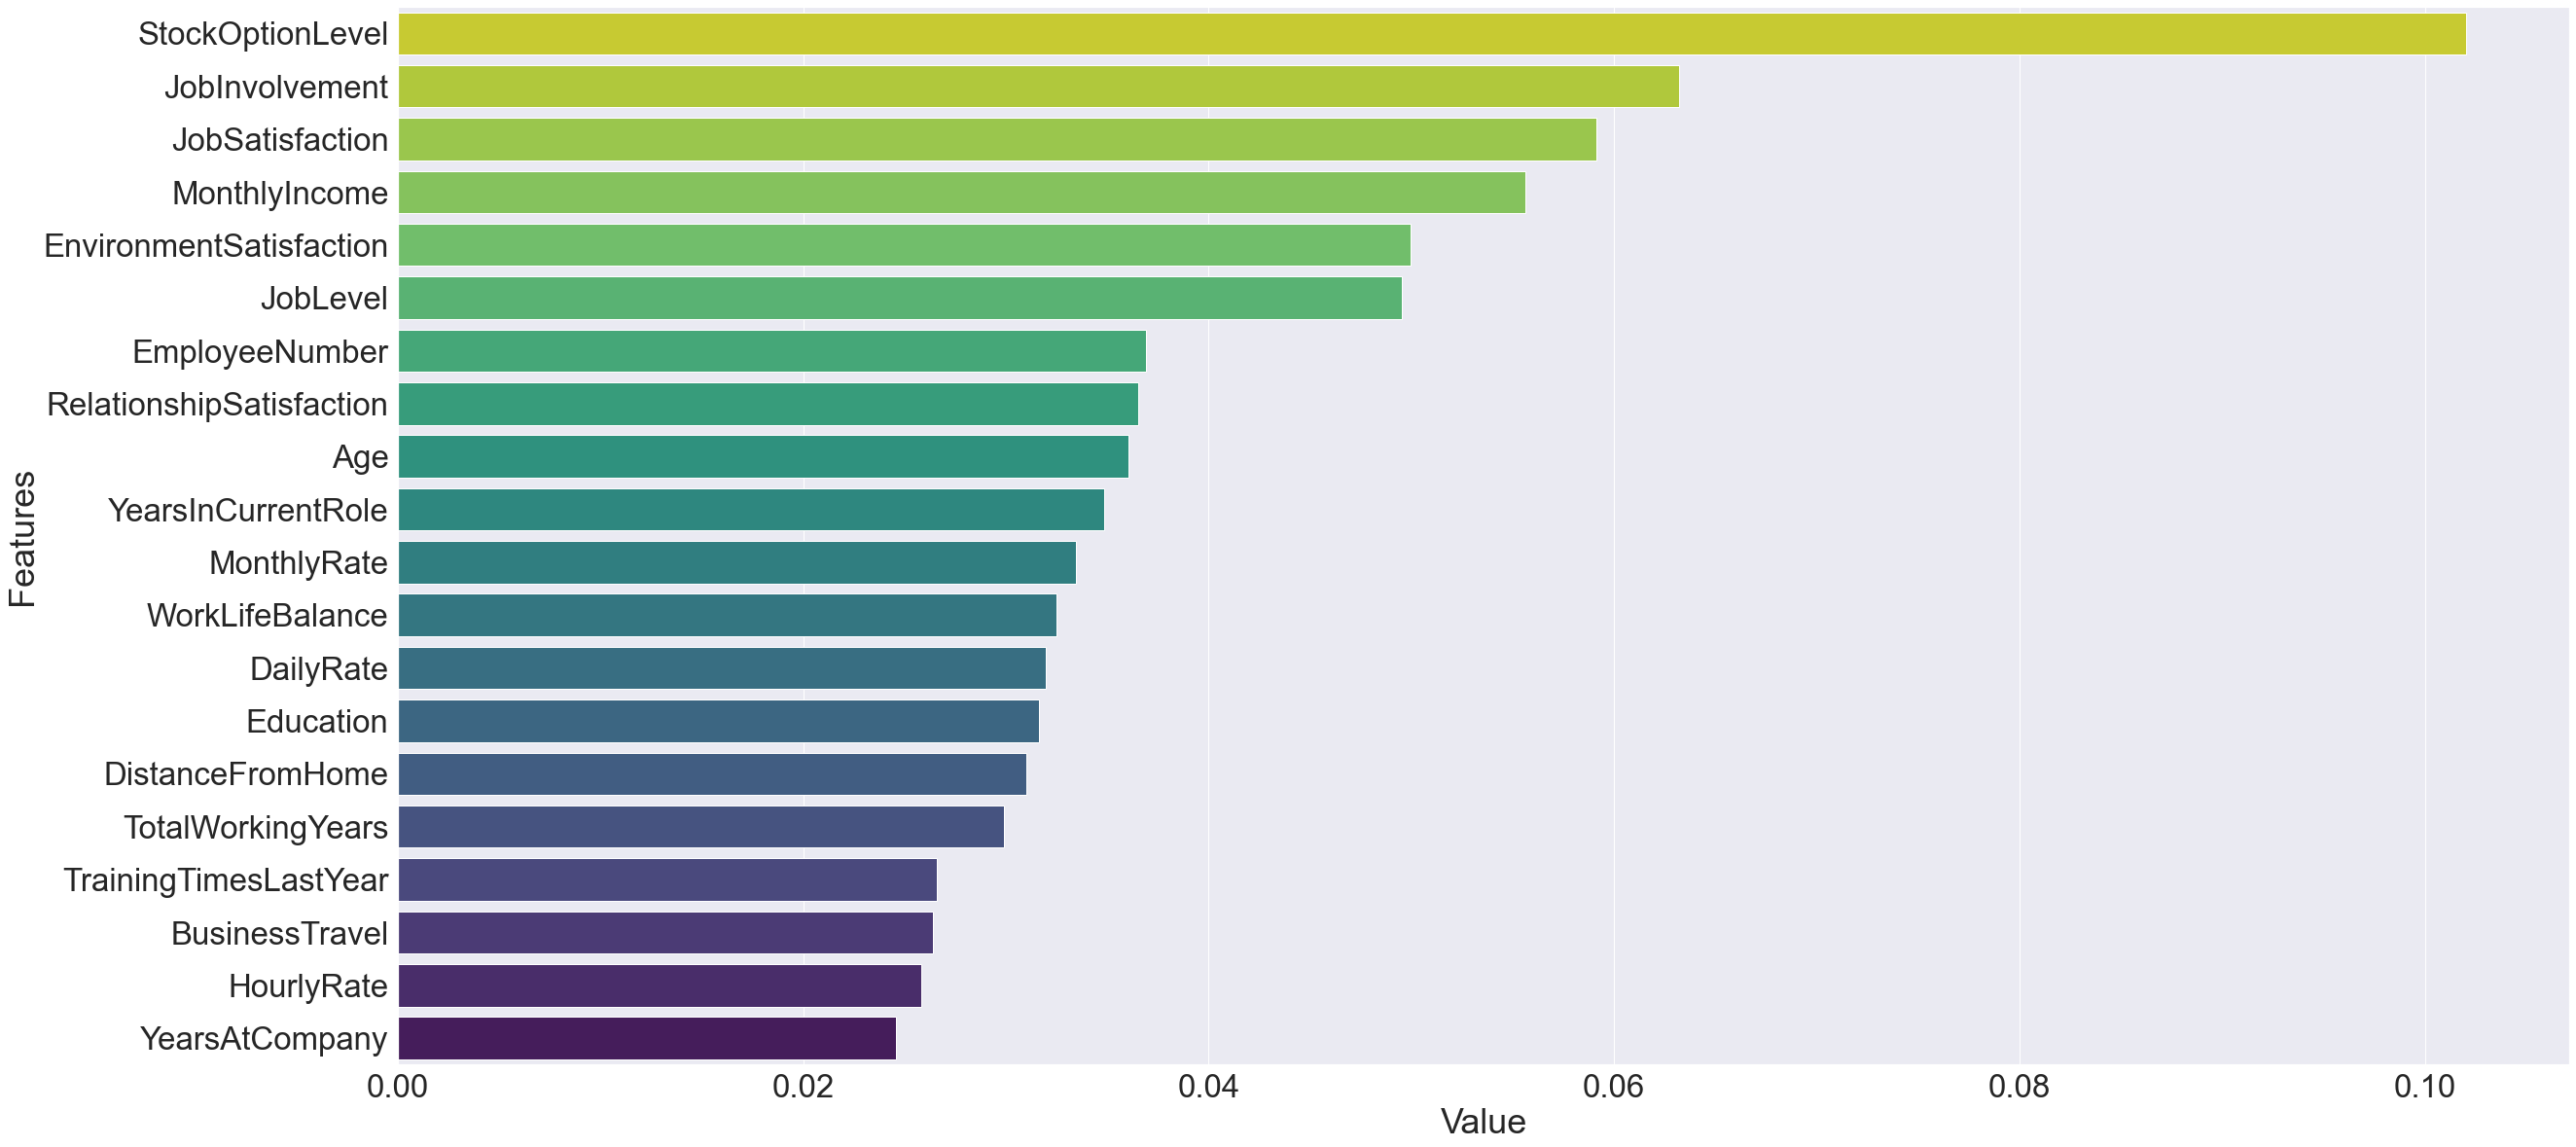

In [71]:
clf = RandomForestClassifier(n_estimators = 40, random_state = 6)
clf.fit(X_enc_train_sm, y_enc_train_sm)
    
plotImp(clf, X_enc_train_sm, num=20) #here specify the mode, your columns, and the # of features you want to see

## Feature Importance Using LightGBM

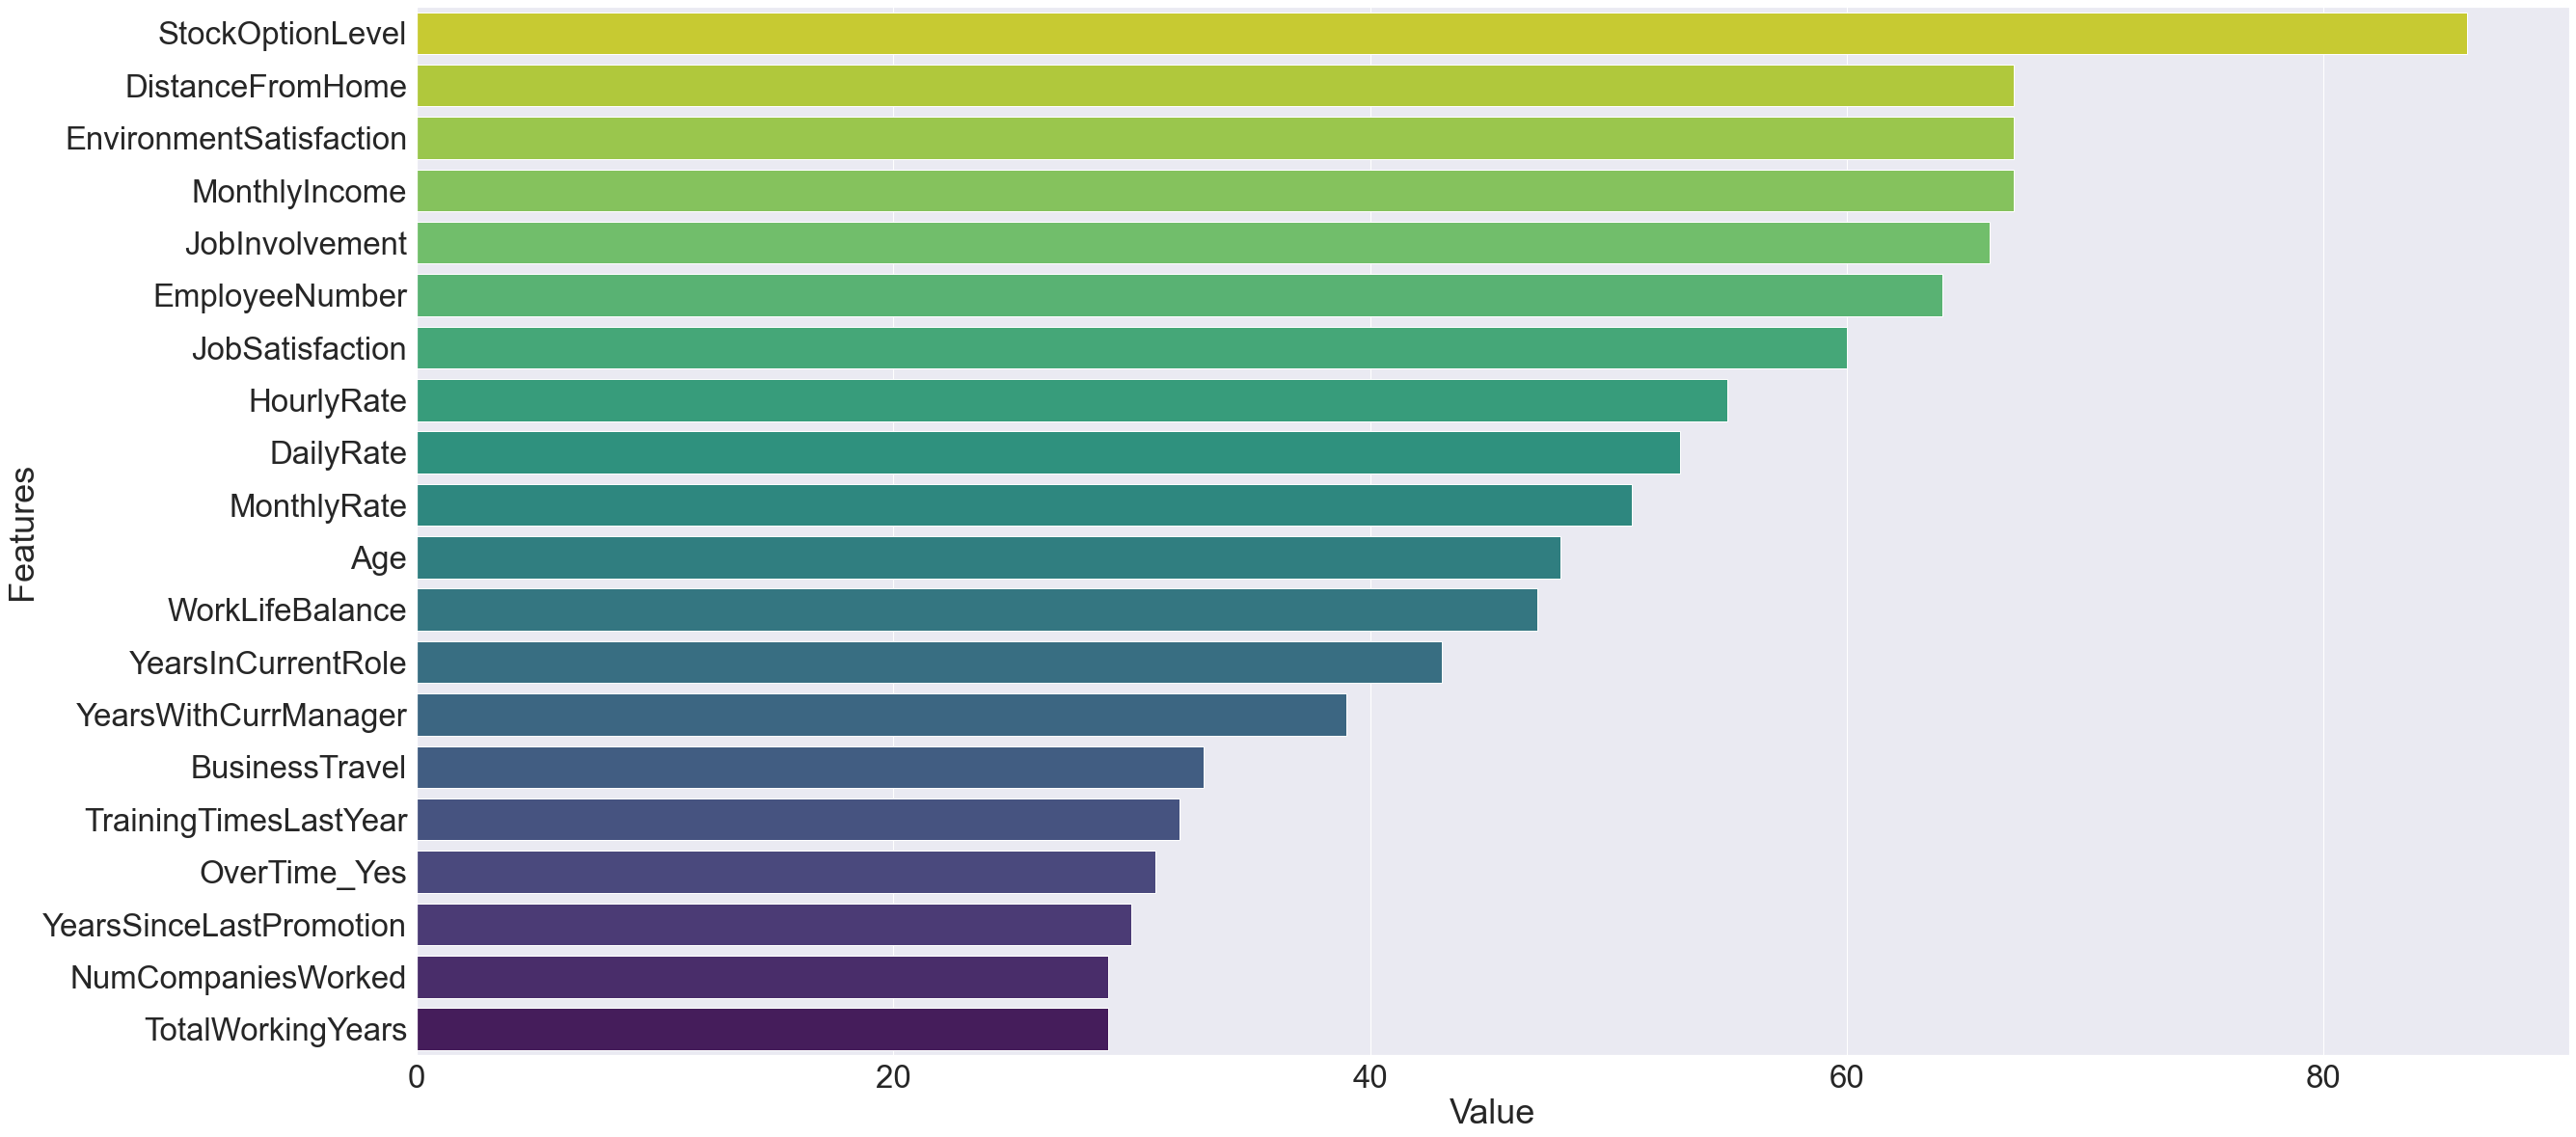

In [72]:
clf = LGBMClassifier(n_estimators = 40, random_state = 6)
clf.fit(X_enc_train_sm, y_enc_train_sm)
    
plotImp(clf, X_enc_train_sm, num=20) #here specify the mode, your columns, and the # of features you want to see

## Feature Importance Using XGBoost

C:\Users\Steven\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


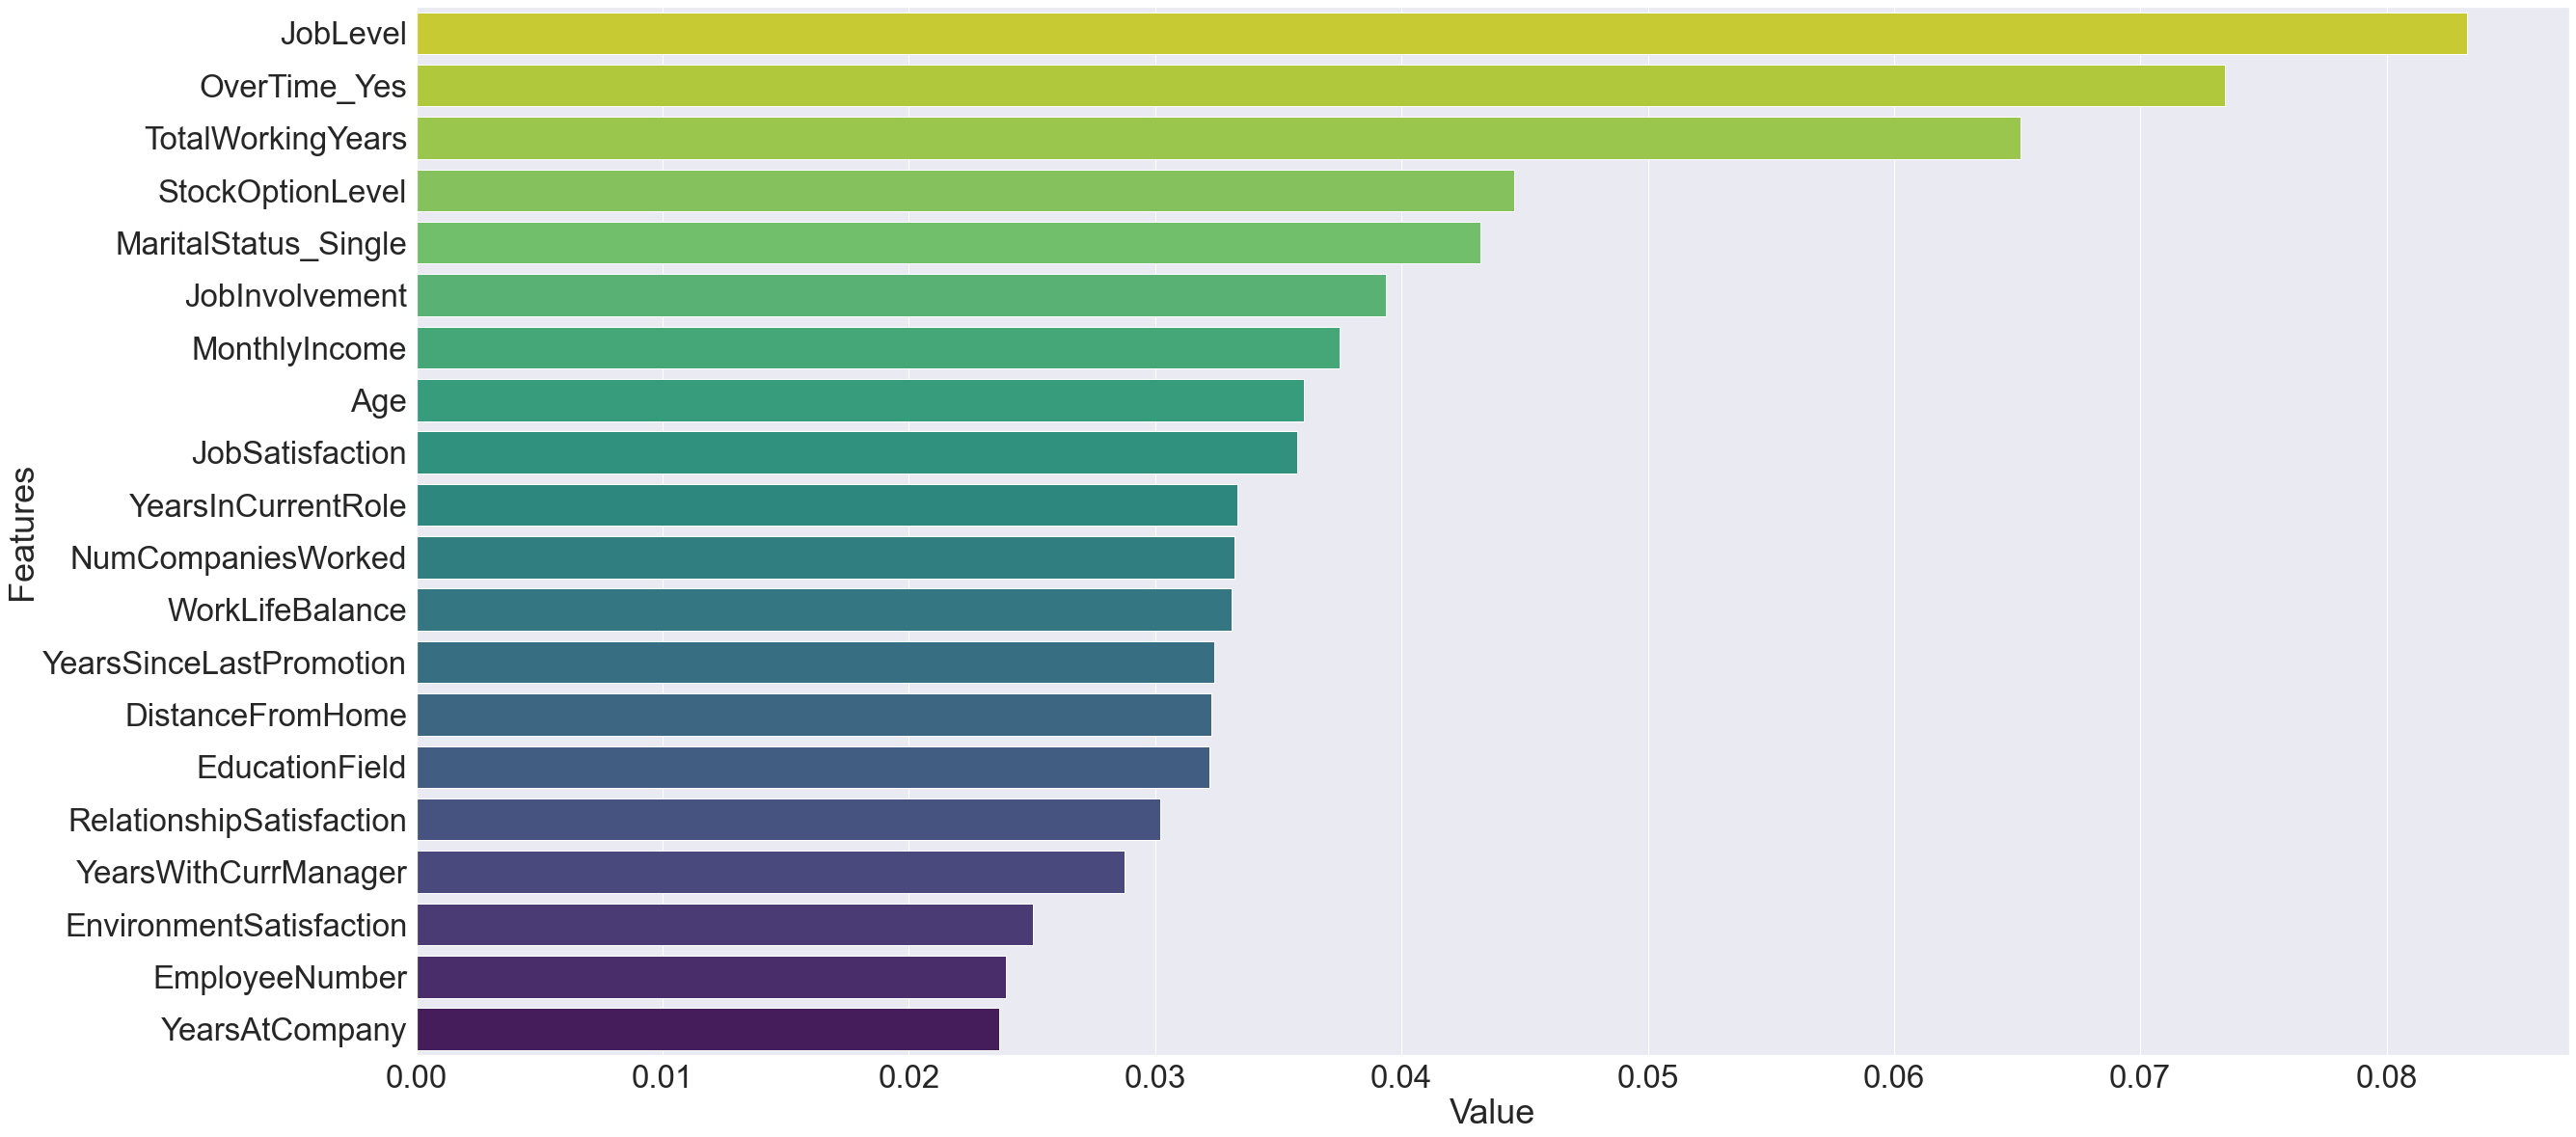

In [73]:
clf = xgb.XGBClassifier(random_state = 6)
clf.fit(X_enc_train, y_enc_train)
    
plotImp(clf, X_enc_train, num=20) #here specify the mode, your columns, and the # of features you want to see

## Feature Importance Using AdaBoost

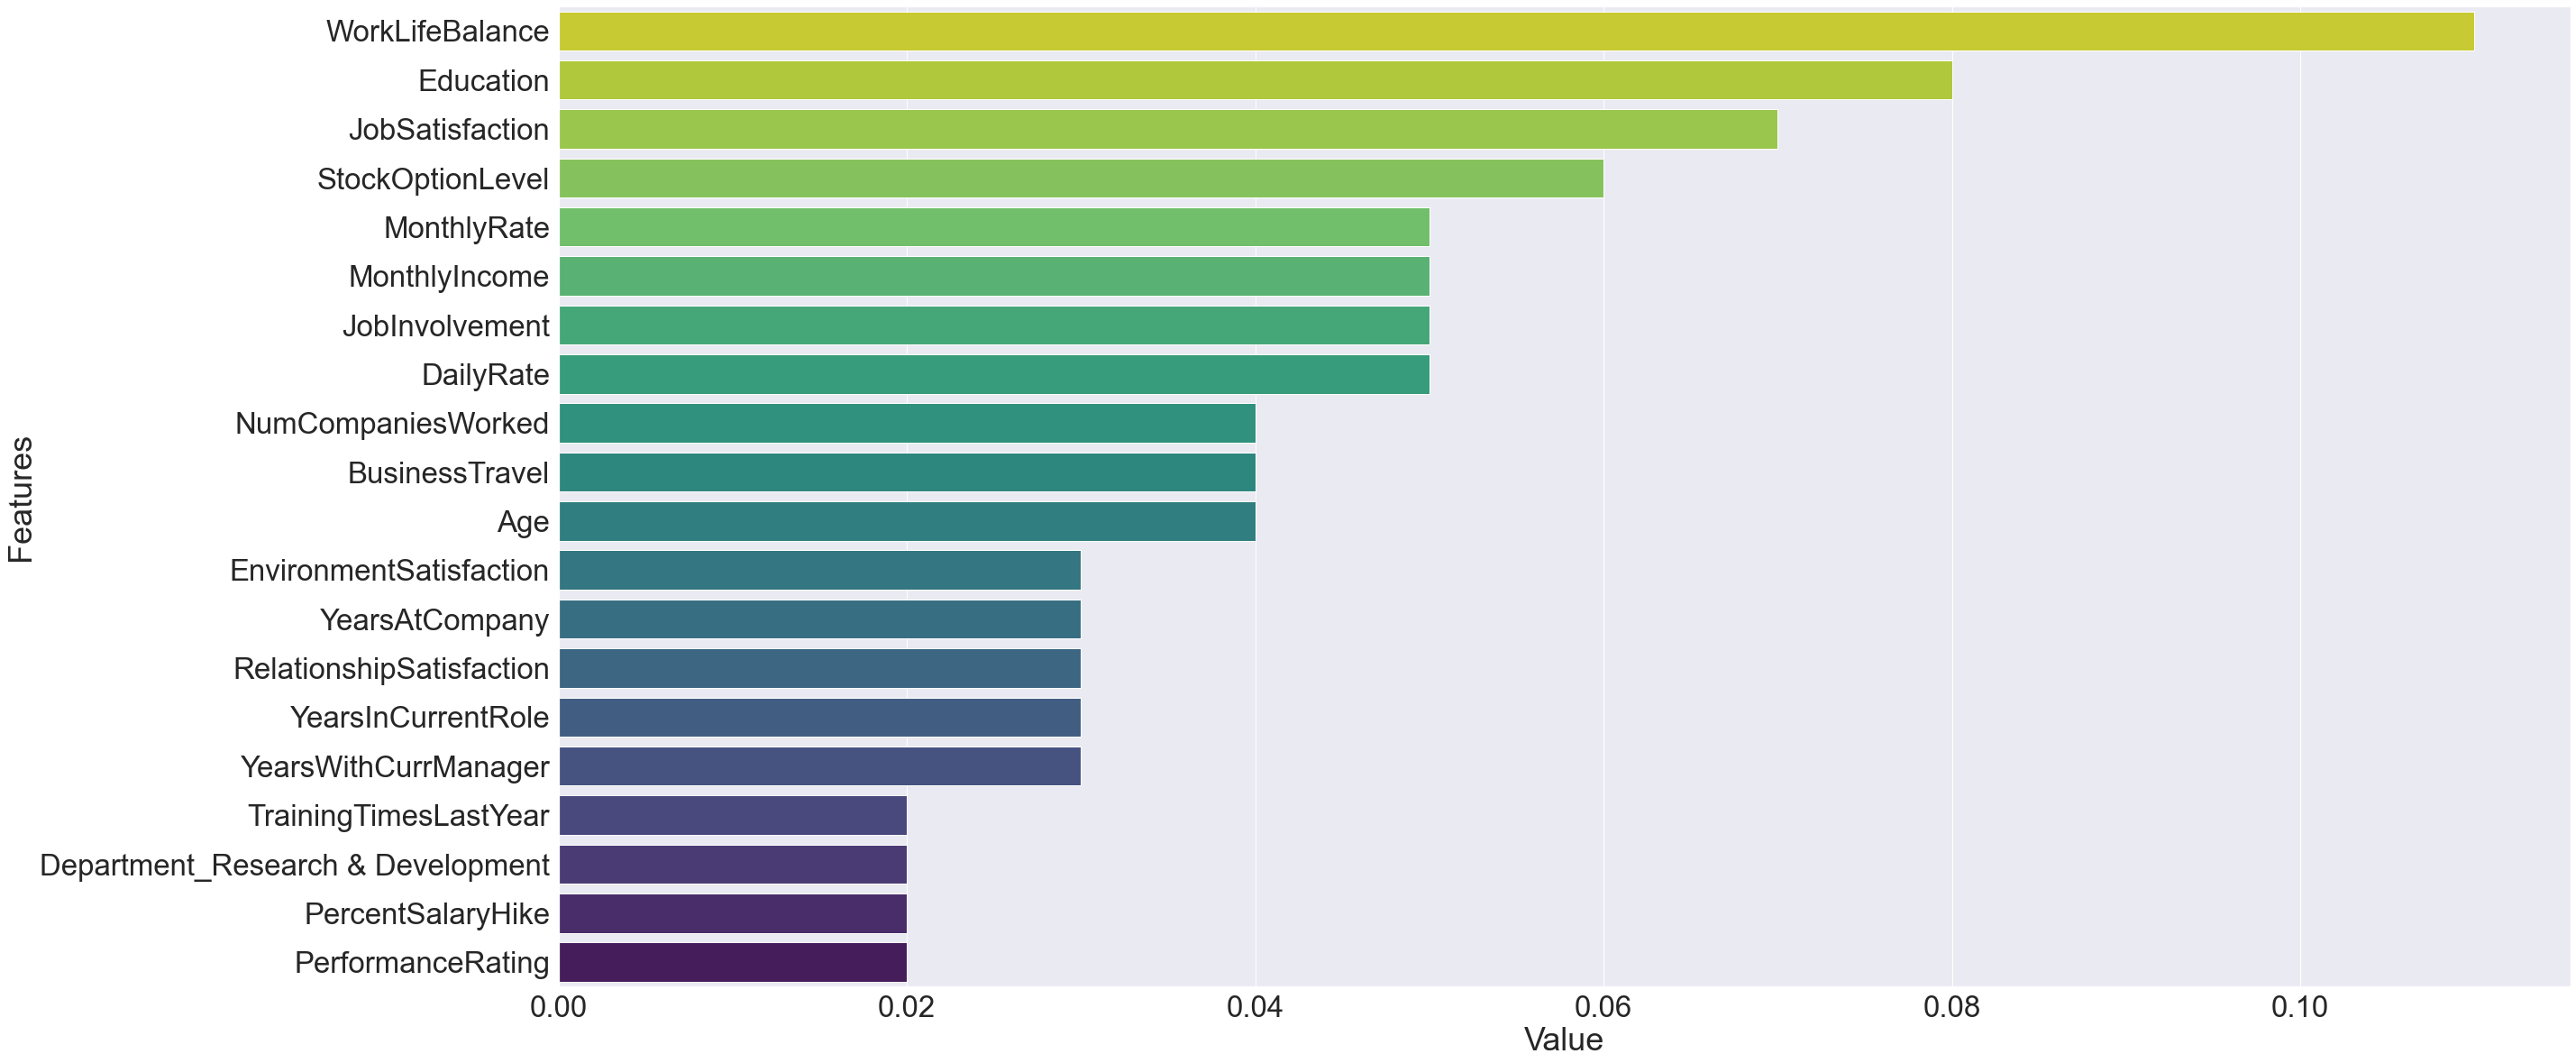

In [74]:
clf = AdaBoostClassifier(n_estimators = 100, random_state = 6)
clf.fit(X_enc_train_sm, y_enc_train_sm)

plotImp(clf, X_enc_train_sm, num=20) #here specify the mode, your columns, and the # of features you want to see

# For Reference

#### Classification Metrics<br>
Gives classification model metric scores

In [ ]:
def evaluation_metrics(y_actual, y_pred):
            
        precision, recall, _ = precision_recall_curve(y_actual, y_pred)
        average_precision = average_precision_score(y_actual, y_pred)
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_actual, y_pred)
        roc_auc = roc_auc_score(y_actual, y_pred)
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_actual, y_pred)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_actual, y_pred)))